# 빅데이터처리
## Week07_Quiz
### 2016003709 윤가영

In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import copy

In [4]:
def create_dataset(N, D=10, K=None):
    if K is None:
        K = math.ceil(math.sqrt(N)/2)
        
    def create_normal_dist(n):
        mu = np.random.randint(-100, 100, size=(D,)) / 100. * D
        
        L = np.random.randint(-70, 70, size=(D,D)) / 100.
        cov = np.dot(L, L.transpose())
        
        t = np.random.multivariate_normal(mu, cov, n)
        return t
    
    dataset = list()
    Csize = int(N / K)
    for k in range(K):
        dataset_c = np.zeros((Csize, D+1))
        #gen IDs
        dataset_c[:, 0] = k
        dataset_c[:, 1:D+1] = create_normal_dist(Csize)
        dataset.extend(dataset_c)
        
    return np.array(dataset)

#### 가장 가까운 클러스터의 idx를 반환하는 함수

In [5]:
def find_closest(point, center, K):
    centerId = -1
    min_dist = np.Inf

    for i in range(K):
        dist = np.sqrt(np.sum((center[i][1] - point)**2))
        if(dist < min_dist):
            min_dist = dist
            centerId = center[i][0]

    return centerId

#### Quiz 해답

In [6]:
def Quiz(N, cluster=[10,20,40,80], convergenceTol=0.001, maxIter=50):
    duration = []
    result = []
    
    for k in cluster:
        dataset = create_dataset(N, K=k)
        
        start = time.time()
        
        inputRDD = sc.parallelize(dataset).map(lambda s: (s[0], s[1:])).cache()
        center = inputRDD.map(lambda s: (s[0], (1,s[1]))).reduceByKey(lambda x,y: ((x[0]+y[0]), x[1]+y[1])).mapValues(lambda v: v[1]/v[0]).collect()
        pr = sc.broadcast(center)
        
        prev = inputRDD.map(lambda t: np.sqrt(np.sum((pr.value[int(t[0])][1] - t[1])**2))).sum()
        
        for _ in range(maxIter):
            inputRDD = inputRDD.map(lambda s: (find_closest(s[1], center, k), s[1])).cache()
            center = inputRDD.map(lambda s: (s[0], (1,s[1]))).reduceByKey(lambda x,y: ((x[0]+y[0]), x[1]+y[1])).mapValues(lambda v: v[1]/v[0]).collect()
            pr = sc.broadcast(center)
            
            # test convergence
            err = inputRDD.map(lambda t: np.sqrt(np.sum((pr.value[int(t[0])][1] - t[1])**2))).sum()
            if abs(prev - err) < convergenceTol:
                prev = err
                break

            # save prev-error value
            prev = err
        
        end = time.time()
        
        result.append(center)
        duration.append(end-start)
        
    return duration    

#### Quiz 실행코드

In [7]:
X = [1000, 2000, 4000, 8000, 16000]

In [8]:
durations = []

for x in X:
    print("[Dataset: {}]".format(x))
    print()

    duration = Quiz(x)

    print("# of cluster : 10")
    print("Duration: {}".format(duration[0]))
    print()
    print("# of cluster : 20")
    print("Duration: {}".format(duration[1]))
    print()
    print("# of cluster : 40")
    print("Duration: {}".format(duration[2]))
    print()
    print("# of cluster : 80")
    print("Duration: {}".format(duration[3]))
    print()
    print("================================")
    print()

    durations.append(duration)

[Dataset: 1000]

# of cluster : 10
Duration: 10.415163040161133

# of cluster : 20
Duration: 2.476116418838501

# of cluster : 40
Duration: 2.8163578510284424

# of cluster : 80
Duration: 3.3927273750305176


[Dataset: 2000]

# of cluster : 10
Duration: 2.455453634262085

# of cluster : 20
Duration: 4.275258302688599

# of cluster : 40
Duration: 3.7587835788726807

# of cluster : 80
Duration: 7.180518627166748


[Dataset: 4000]

# of cluster : 10
Duration: 2.7537453174591064

# of cluster : 20
Duration: 5.840237379074097

# of cluster : 40
Duration: 8.93427848815918

# of cluster : 80
Duration: 19.88587474822998


[Dataset: 8000]

# of cluster : 10
Duration: 4.03127384185791

# of cluster : 20
Duration: 13.555373191833496

# of cluster : 40
Duration: 19.05179262161255

# of cluster : 80
Duration: 16.347975492477417


[Dataset: 16000]

# of cluster : 10
Duration: 10.294225215911865

# of cluster : 20
Duration: 10.829514026641846

# of cluster : 40
Duration: 34.18788290023804

# of clust

#### 그래프

In [9]:
th = [10, 20, 40, 80]
marker = ['^', 's', 'h', 'o']

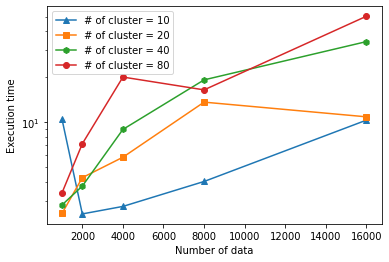

In [20]:
for i in range(4):
    result = []
    for j in range(5):
        result.append(durations[j][i])
    
    plt.plot(X, result, marker=marker[i], label="# of cluster = {}".format(th[i]))


plt.xlabel("Number of data")
plt.ylabel("Execution time")

plt.yscale('log')
plt.legend(loc='upper left', fontsize=10)

plt.show()